In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import os
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import re
import seaborn as sns
from utils import pad_images
sns.set_palette('colorblind')
sns.set_style('darkgrid')
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from model import RegressionModel

In [2]:
import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # If using GPU
torch.backends.cudnn.benchmark = False    # If using GPU


# Read and Preprocess images

In [3]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('data')):
    for filename in tqdm(sorted(filenames)):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data, dtype='object')

100%|██████████| 2048/2048 [00:00<00:00, 2998.52it/s]


In [4]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
padded_data.shape

(2048, 256, 256, 1)

In [5]:
# Transpose to feed into torch model
data_t = np.transpose(padded_data, (0, 3, 1, 2))

In [6]:
X = data_t.copy()/255
y = pd.read_csv('label.csv')['label'].values
del padded_data
del data_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
del X, y
torch.cuda.empty_cache()

In [7]:
#define data loaders
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(device=device, dtype=torch.float), torch.from_numpy(y_train).to(device=device, dtype=torch.float))
#val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(device=device, dtype=torch.float), torch.from_numpy(y_val).to(device=device, dtype=torch.float))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(device=device, dtype=torch.float), torch.from_numpy(y_test).to(device=device, dtype=torch.float))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=61, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

del X_train, y_train, train_data, test_data

torch.cuda.empty_cache()


# Model Construction

In [8]:
def train(model,X_train,y_train, lr, epochs):
    model = RegressionModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    for epoch in (range(epochs)):
        for images, labels in (train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()



In [1]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(regression_model.parameters(), lr=0.0002500850964289255)

# Training loop
num_epochs =45
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model.to(device)
train_loss = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    val_loss = []

    for images, targets in train_loader:
        regression_model.train()
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = regression_model(images)
        loss = criterion(outputs.squeeze(), targets.float()) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #validate
        regression_model.eval()
        total_val_loss = 0
    train_loss.append(total_loss / len(train_loader))

    


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss/len(val_loader)}")


NameError: name 'nn' is not defined

In [27]:
regression_model = RegressionModel().to(device)
regression_model.load_state_dict(torch.load('model.pth'))
criterion = nn.MSELoss()

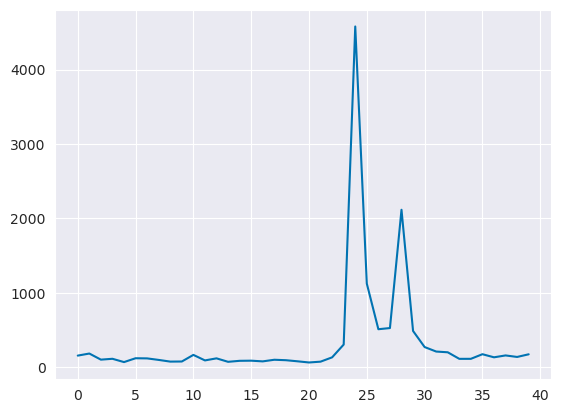

In [124]:
#plt.plot(val_loss, label   ='Validation loss')
plt.plot(train_loss[5:], label='Training loss')

In [28]:
regression_model.eval()
total_test_loss = 0
yhat = []
y = []
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = regression_model(images)
        yhat.append(outputs.squeeze().cpu().numpy().tolist())
        y.append(targets.cpu().numpy().tolist())
        loss = criterion(outputs.squeeze(), targets.float())  
        total_test_loss += loss.item()

avg_test_loss = np.sqrt(total_test_loss / len(test_loader))
print(f"Test RMSE: {avg_test_loss}")

y = np.array(y, dtype=object)
yhat = np.array(yhat , dtype=object)
y = np.concatenate(y)
#yhat = np.concatenate(yhat)

NameError: name 'test_loader' is not defined

In [29]:
#save model
#torch.save(regression_model.state_dict(), 'model.pth')

In [30]:
df = pd.DataFrame(columns=['yhat', 'y'])
df['yhat'] = yhat
df['y'] = y
df.sort_values(by=['y'], inplace=True)

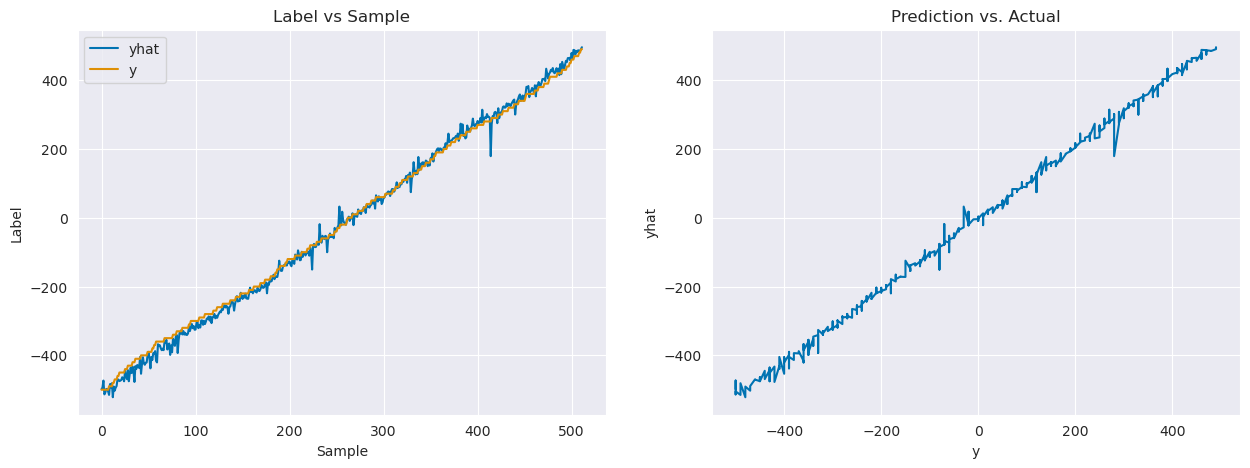

In [11]:
#create suplot with 2 columns and 1 row
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(df['yhat'].values)
ax[0].plot(df['y'].values)
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Label')
ax[0].legend(['yhat', 'y'])
ax[0].set_title('Label vs Sample')

ax[1].plot(df['y'].values, df['yhat'].values)
ax[1].set_xlabel('y')
ax[1].set_ylabel('yhat')
ax[1].set_title('Prediction vs. Actual')

plt.show()

In [12]:
df

yhat      y
345 -498.300537 -500.0
67   -493.66629 -500.0
202 -473.378174 -500.0
260  -513.49762 -500.0
125 -508.093872 -500.0
..          ...    ...
193  487.054535  470.0
336   485.25061  480.0
412  484.884796  480.0
31   490.323334  490.0
273  495.867065  490.0

[512 rows x 2 columns]

# Test with the new video data

In [13]:
del train_loader
del test_loader
torch.cuda.empty_cache()

In [31]:
#read all images with PIL and store in an array
data = []
for dirname, _, filenames in (os.walk('nobackground')):
    for filename in tqdm(sorted(filenames, key=lambda x: int(re.sub('\D', '', x)))):
        if (filename.endswith('.jpg')):
            #print (os.path.join(dirname, filename))
            img = PIL.Image.open(os.path.join(dirname, filename)).convert('L')
            data.append(np.asarray(img).astype('float32'))
            del img
data = np.array(data)/255

100%|██████████| 442/442 [00:00<00:00, 5993.53it/s]


In [32]:
padded_data = pad_images(data,(256,256))
padded_data = padded_data.reshape(padded_data.shape[0],256,256,1)
data_t = np.transpose(padded_data, (0, 3, 1, 2))
data_t = torch.from_numpy(data_t).to(device)

In [33]:
dl = DataLoader(data_t, batch_size=40, shuffle=False)

In [34]:
yhats = []
imgs = []
for i in dl:
    yhat = regression_model (i)
    imgs.append(i.detach().cpu().numpy())
    yhats.append(yhat.detach().cpu().numpy())
    del yhat
    torch.cuda.empty_cache()

In [35]:
yhats = np.concatenate(yhats)
imgs = np.concatenate(imgs)

In [36]:
imgs = np.transpose(imgs, (0,2,3,1))

In [37]:
r = np.arange(0, len(yhats)/20, 1/20)

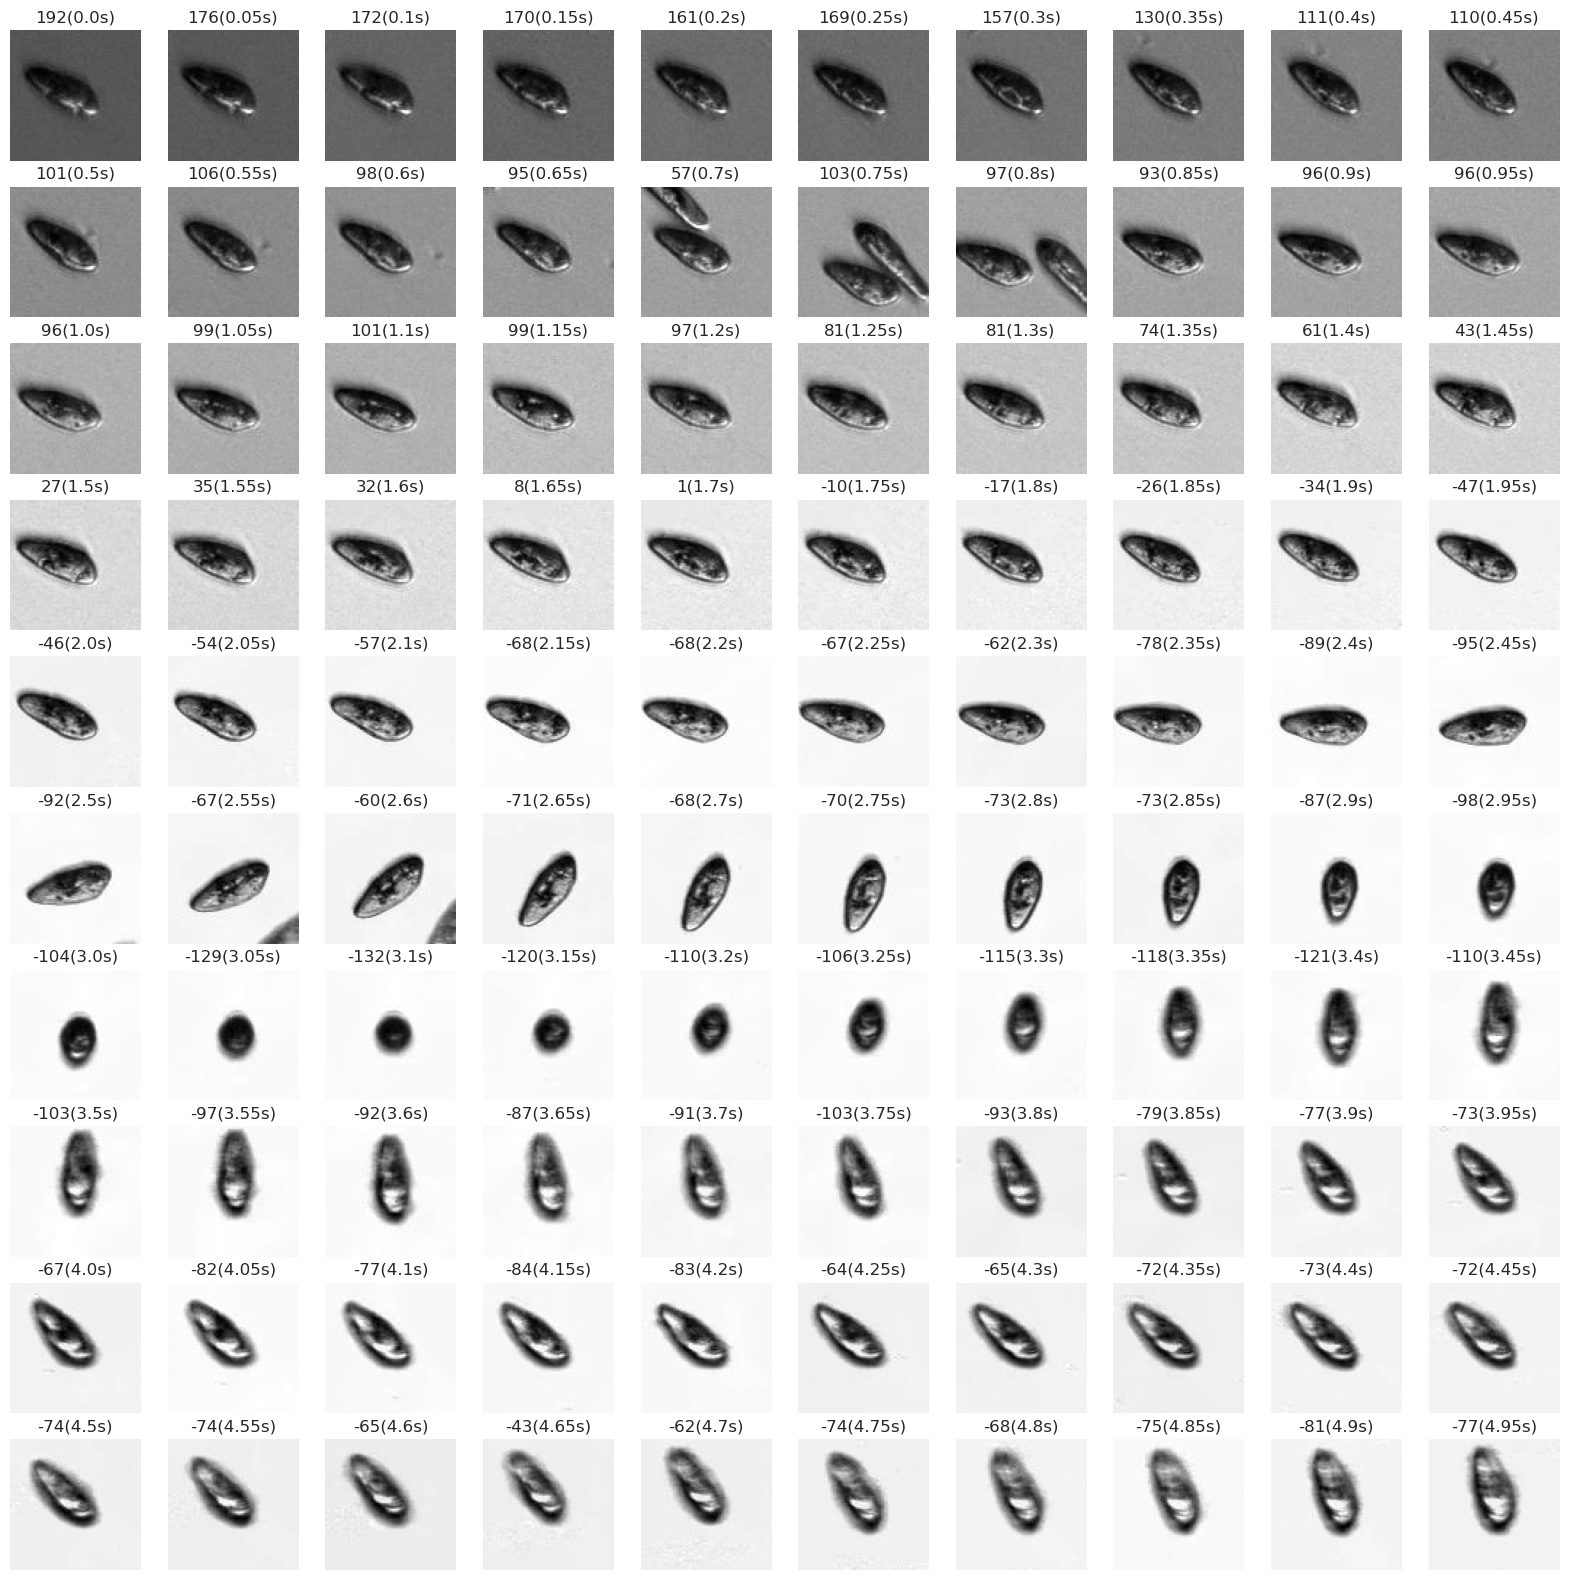

In [38]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax[i//10, i%10].imshow(imgs[i, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[i]))+ '(' + str(np.round(r[i],2)) + 's)')
    ax[i//10, i%10].axis('off')

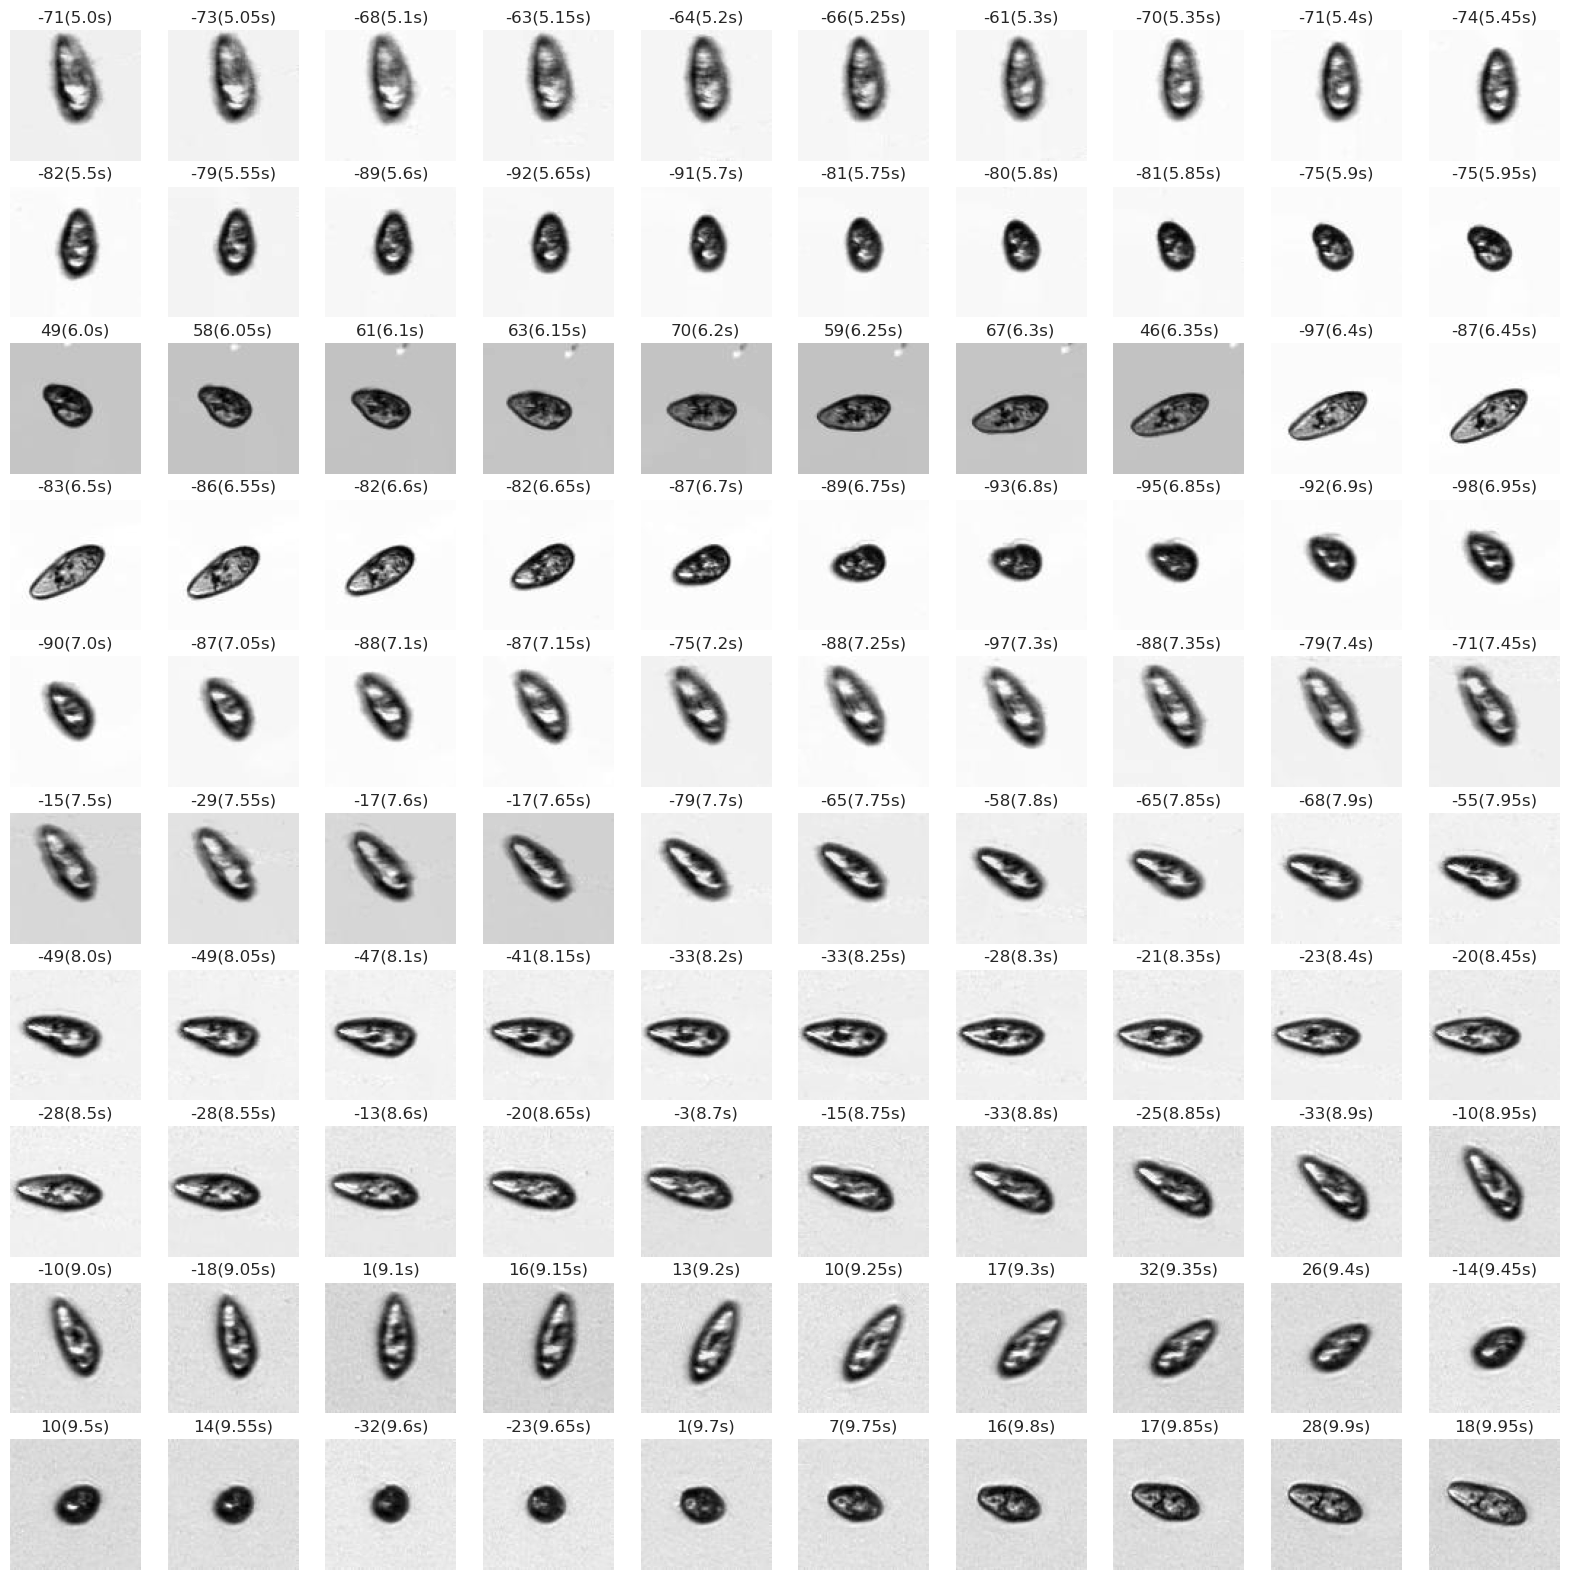

In [39]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(100, 200)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

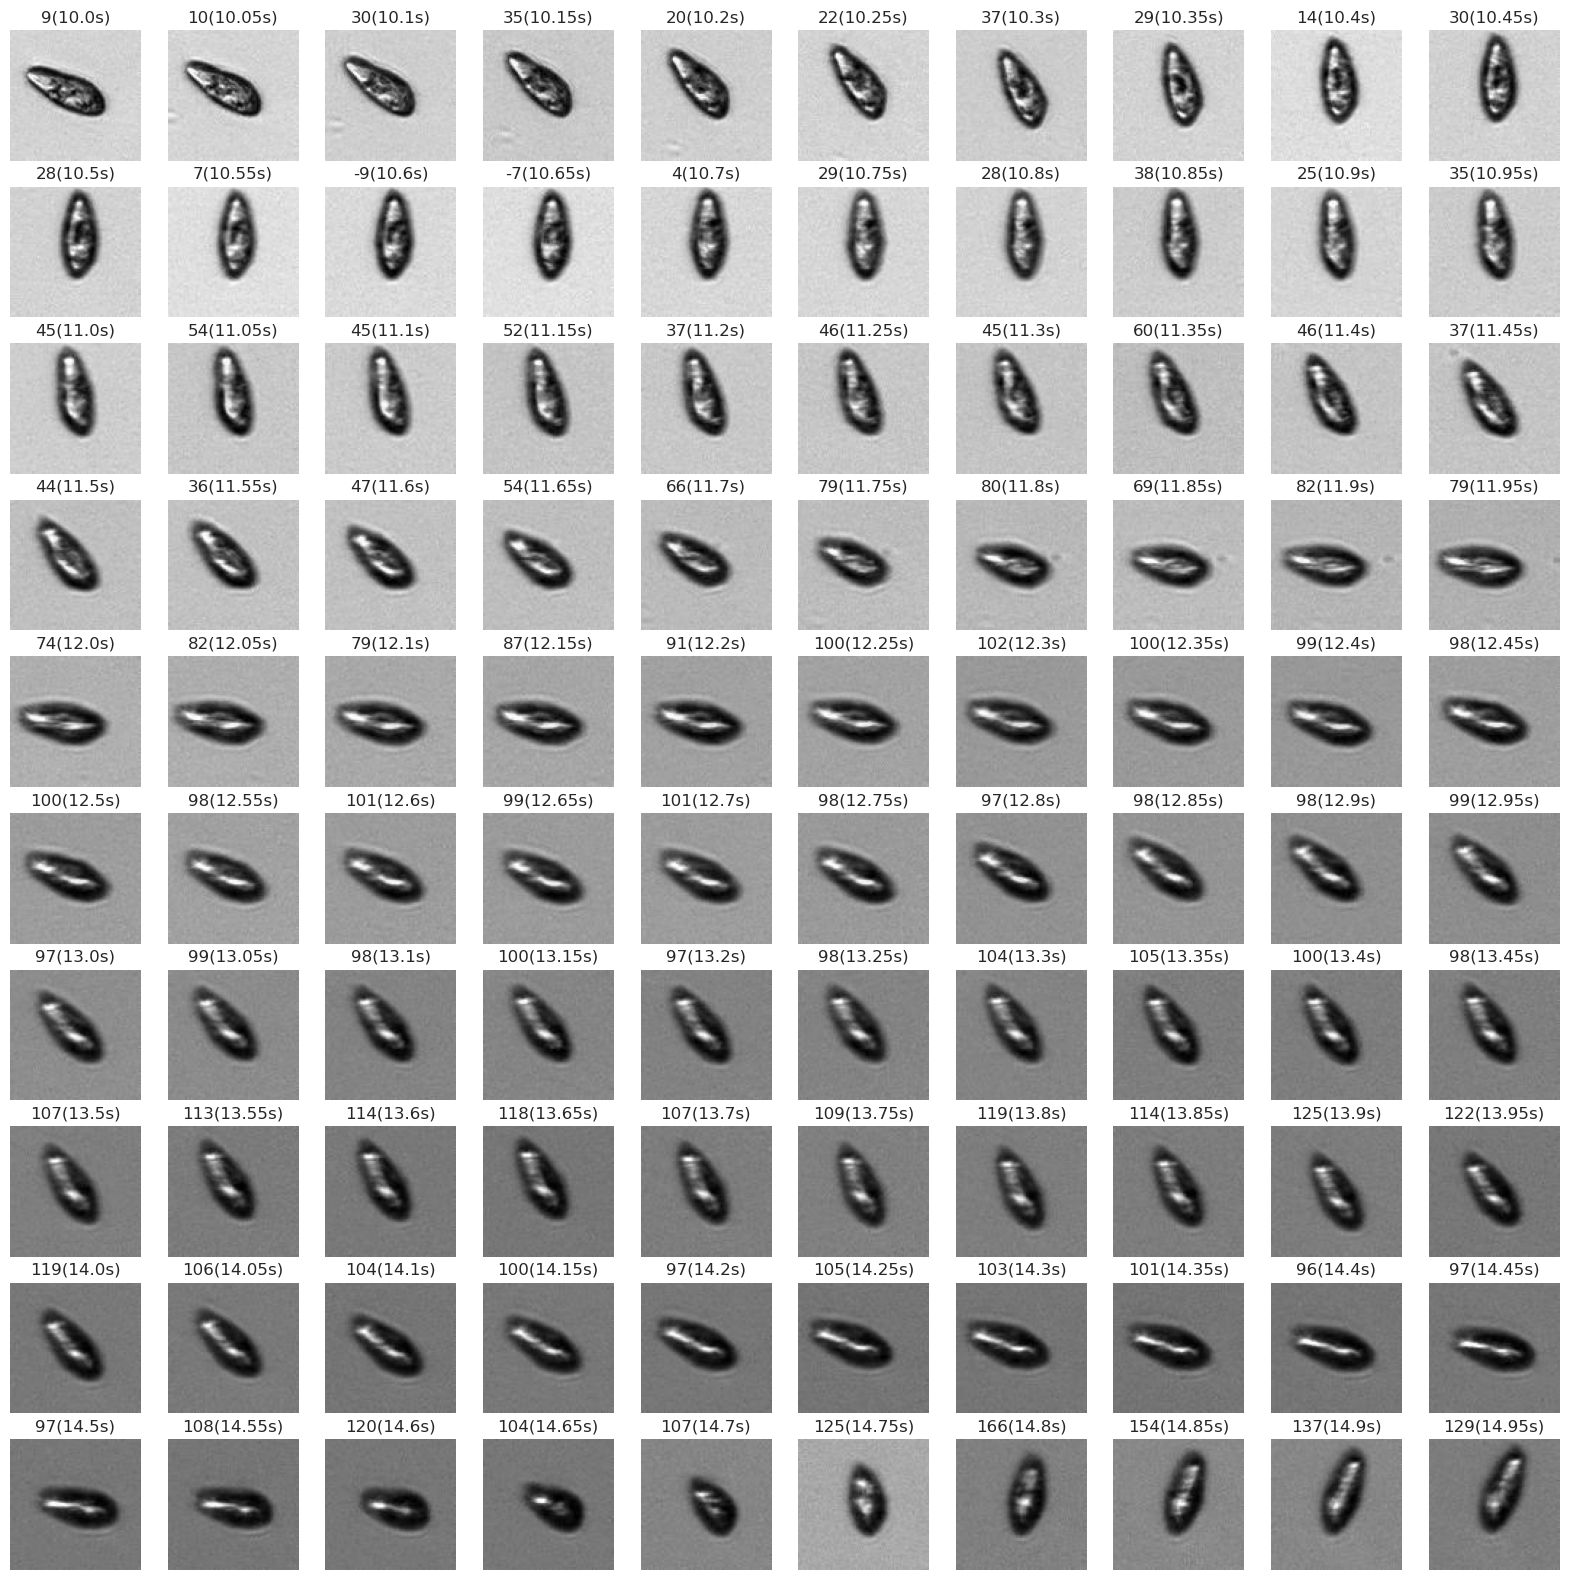

In [40]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(200, 300)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

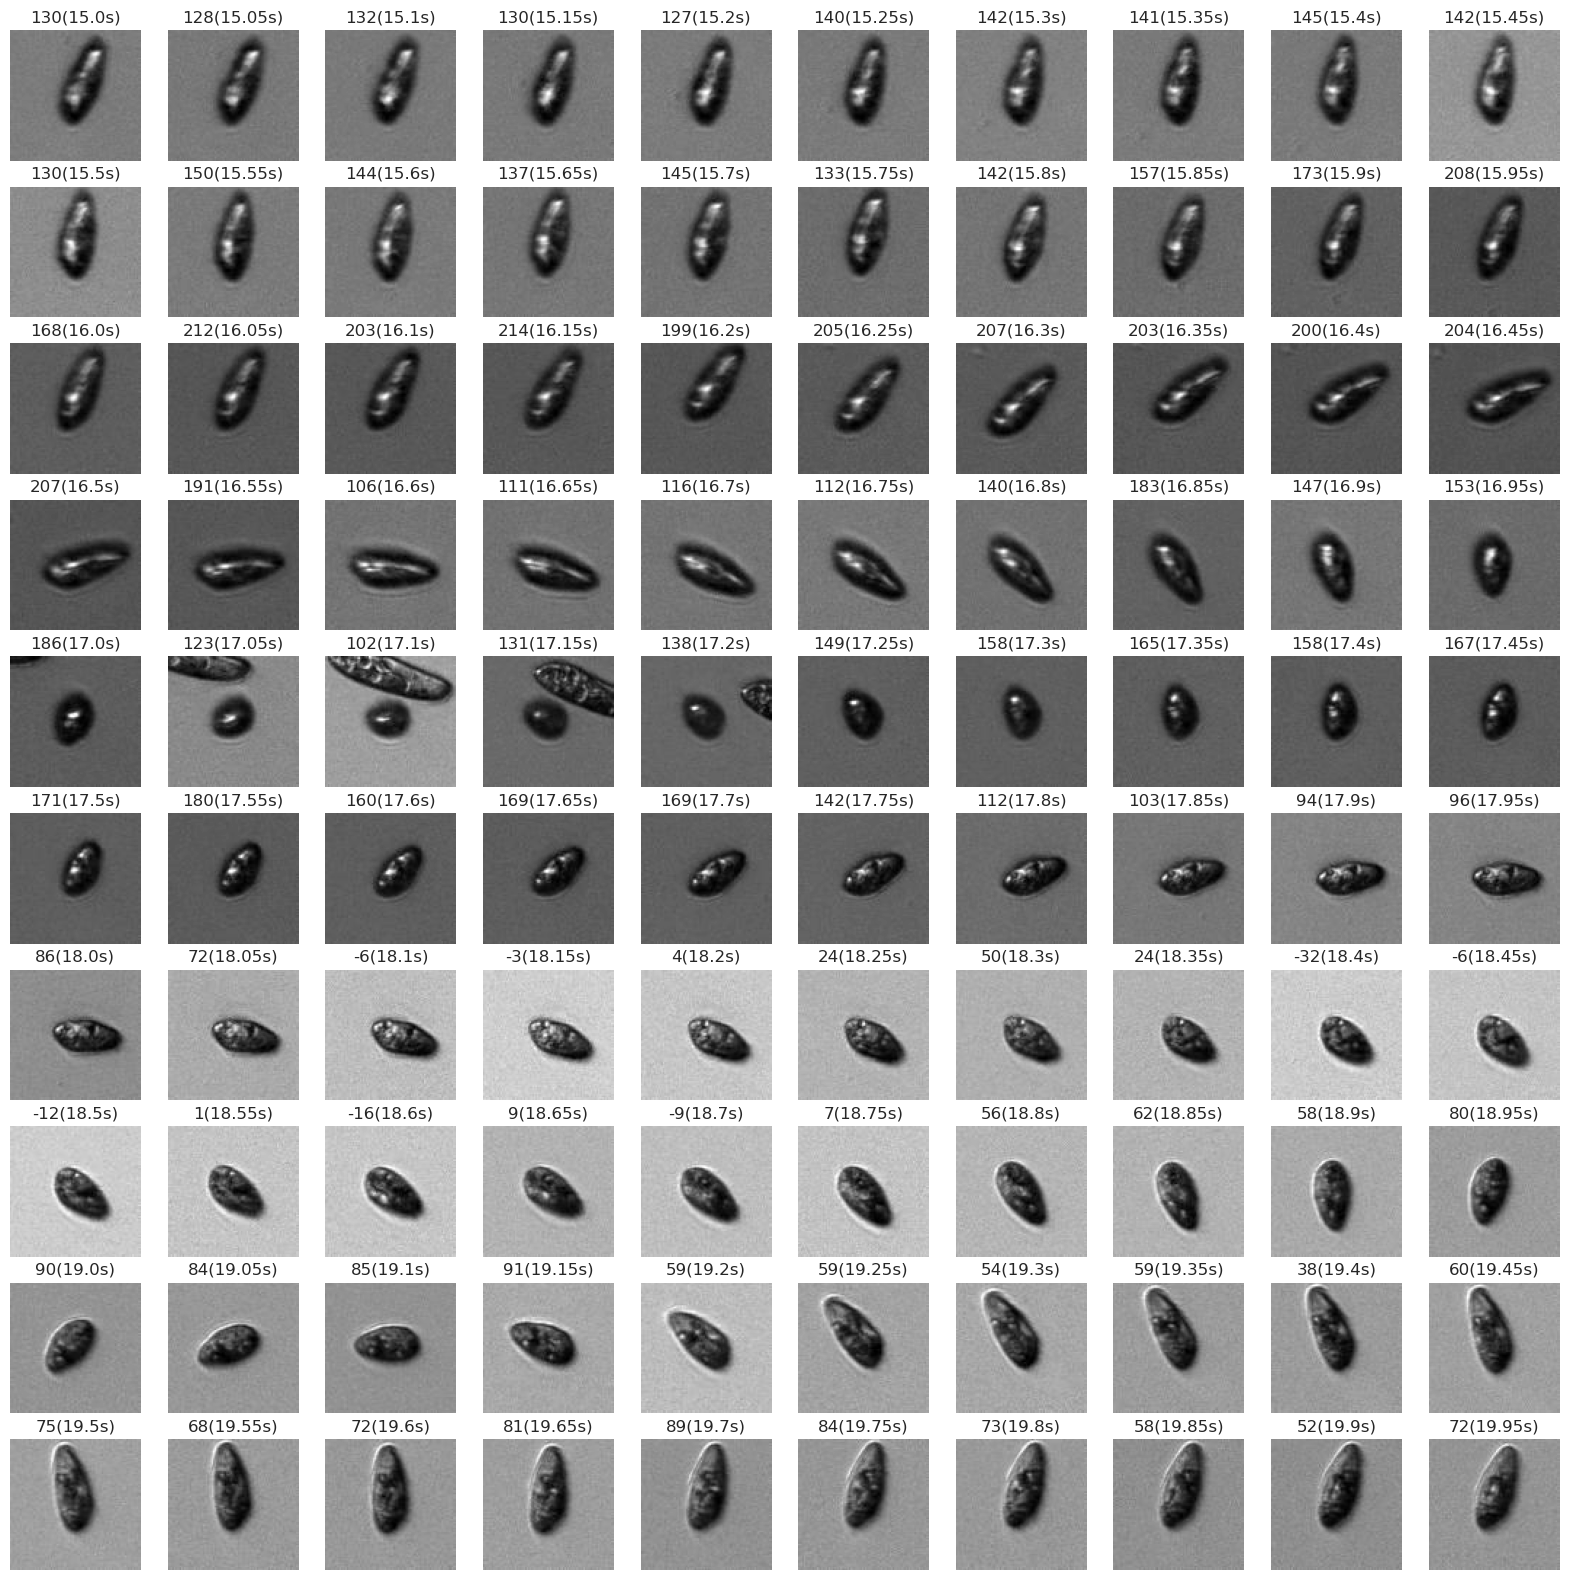

In [41]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i,j in enumerate(range(300, 400)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')

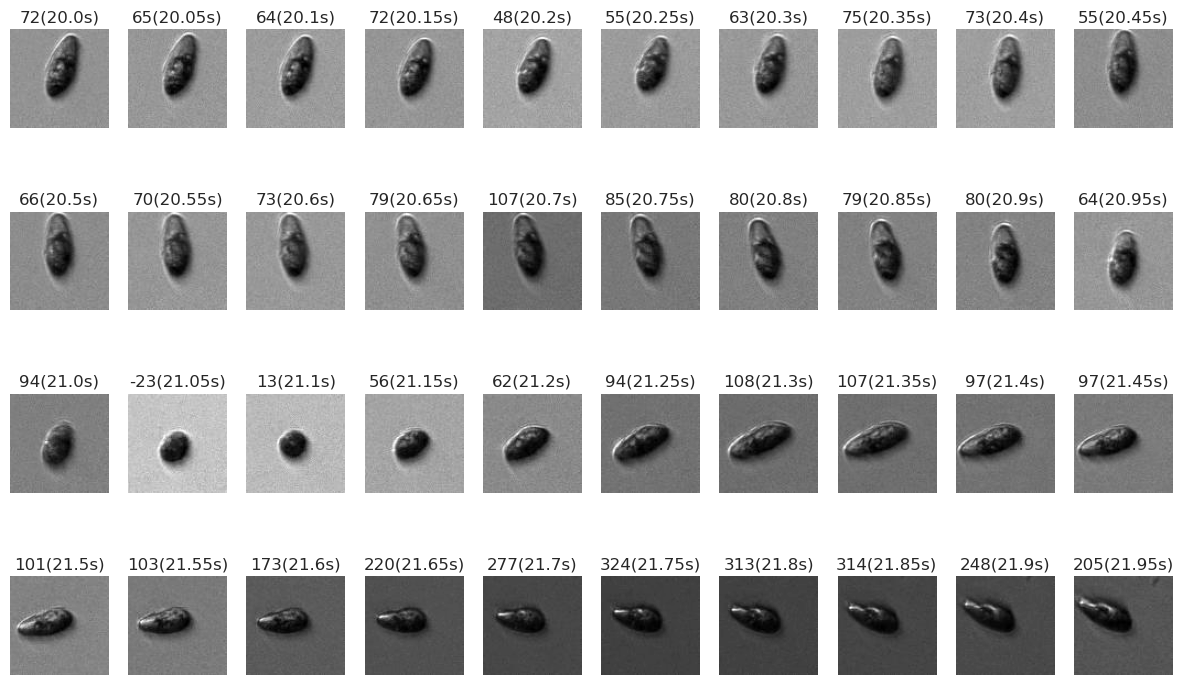

In [42]:

fig, ax = plt.subplots(4, 10, figsize=(15, 15))
for i,j in enumerate(range(400, 440)):
    ax[i//10, i%10].imshow(imgs[j, :90, :90], cmap='gray')
    ax[i//10, i%10].set_title(str(int(yhats[j]))+ '(' + str(np.round(r[j],2)) + 's)')
    ax[i//10, i%10].axis('off')



    #decrease distance betweeen subplots
    plt.subplots_adjust( hspace=-0.7)

In [76]:
#Save yhats to txt
#np.savetxt("yhat.txt", yhats, fmt="%s")

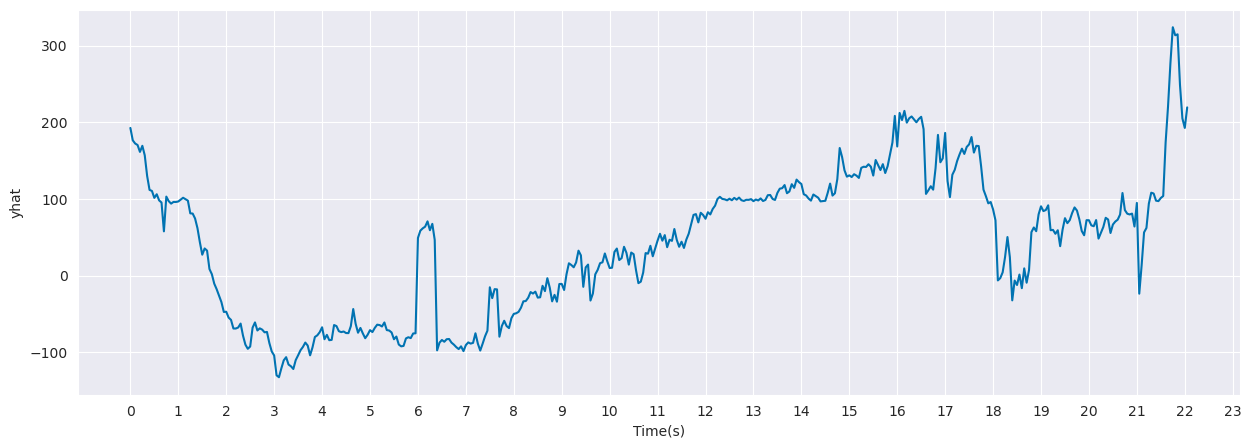

In [43]:
plt.figure(figsize=(15, 5))
plt.plot (r, yhats)
plt.ylabel('yhat')
plt.xlabel('Time(s)')
#make the x scale more precise
plt.xticks(np.arange(min(r), max(r)+1, 1))
plt.show()